In [17]:
#!pip install avalanche-lib==0.3.1
#!pip install torcheval


Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.8 MB/s eta 0:00:00m eta 0:00:010:00:10
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.1 requires torch==1.9.1, but you have torch 1.11.0 which is incompatible.
torchtext 0.10.1 requires torch==1.9.1, but you have torch 1.11.0 which is incompatible.
torchdata 0.5.1 requires torch==1.13.1, but you have torch 1.11.0 which is incompatible.
torchaudio 0.9.1 requires torch==1.9.1, but you have torch 1.11.0 which is incompatible.
pytorch-lightning 2.1.2 requires torch>=1.12.0, but you have torch 1.11.0 which is incompatible.
neurips-2022-generative-h

In [1]:
from itertools import product
from itertools import combinations

from avalanche.benchmarks.classic import SplitMNIST
from avalanche.benchmarks.generators import dataset_benchmark


import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter



import torch.nn.functional as F
from torcheval.metrics.functional import multiclass_confusion_matrix
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from torchvision.utils import save_image
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision import transforms

from itertools import product
from itertools import combinations


import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.animation import FuncAnimation ,FFMpegWriter

import dill
import numpy as np
import os
import json
import pandas as pd
from tqdm import tqdm
import copy

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
#split_mnist = SplitMNIST(n_experiences=10)

In [4]:
'''for i in split_mnist.train_stream[0].dataset:
    print(i[0].shape)
    print(i[1])
    break
'''

torch.Size([1, 28, 28])
6


In [5]:
#split_mnist.train_stream[0].dataset[0][1]

6

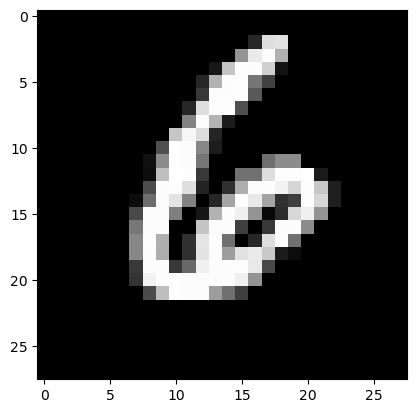

In [6]:
#import matplotlib.pyplot as plt
#plt.imshow(split_mnist.train_stream[0].dataset[0][0].numpy()[0], cmap='gray')

In [8]:
#len(split_mnist.train_stream)

10

### Data creation

In [ ]:
for k in range(10):
    if not(os.path.isdir(".//data//SplitMnist//train//")):
        os.mkdir(".//data//SplitMnist//train//")
    if not(os.path.isdir(".//data//SplitMnist//train//{}".format(k))):
        os.mkdir(".//data//SplitMnist//train//{}".format(k))
    if not(os.path.isdir(".//data//SplitMnist//test//")):
        os.mkdir(".//data//SplitMnist//test//")
    if not(os.path.isdir(".//data//SplitMnist//test//{}".format(k))):
        os.mkdir(".//data//SplitMnist//test//{}".format(k))
for i in tqdm(range(len(split_mnist.train_stream))):
    for j in range(len(split_mnist.train_stream[i].dataset)):
        save_image(split_mnist.train_stream[i].dataset[j][0], ".//data//SplitMnist//train//{}//{}.png".format(split_mnist.train_stream[i].dataset[j][1],j))
    #print("fold {}//{}//{}.png saved".format(j,L_labels1[img_idx],test_index[img_idx]))

In [ ]:
for i in tqdm(range(len(split_mnist.test_stream))):
    for j in range(len(split_mnist.test_stream[i].dataset)):
        save_image(split_mnist.test_stream[i].dataset[j][0], ".//data//SplitMnist//test//{}//{}.png".format(split_mnist.test_stream[i].dataset[j][1],j))

In [3]:
from torchvision import datasets
IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

class ClassSpecificImageFolder(datasets.DatasetFolder):
    def __init__(
            self,
            root,
            dropped_classes=[],
            transform = None,
            target_transform = None,
            loader = datasets.folder.default_loader,
            is_valid_file = None,
    ):
        self.dropped_classes = dropped_classes
        super(ClassSpecificImageFolder, self).__init__(root, loader, IMG_EXTENSIONS if is_valid_file is None else None,
                                                       transform=transform,
                                                       target_transform=target_transform,
                                                       is_valid_file=is_valid_file)
        self.imgs = self.samples

    def find_classes(self, directory):
        classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        classes = [c for c in classes if c not in self.dropped_classes]
        if not classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

# Single experiences

In [4]:
ListExperiences=list()

All=list(range(10))
for sample in range(2,9,1):
    S=combinations(range(10), sample)
    #All=list(range(10))
    for i in S :
        L1=list(i)
        L2=[k for k in All if k not in L1] 
        ListExperiences.append(L1)
len(ListExperiences)

1002

# Pairs of experiences (with and without repetition)

In [ ]:
Pairs_exp=list()

All=list(range(10))
for sample in range(2,9,1):
    S=combinations(range(10), sample)
    #All=list(range(10))
    for i in S :
        L1=list(i)
        L2=[k for k in All if k not in L1] 
        for sample2 in range(2,9,1):
            S2=combinations(L2, sample2)
            for j in S2:
                pair=[]
                pair.append(L1)
                sub=list(j)
                pair.append(sub)
                Pairs_exp.append(pair)
len(Pairs_exp)

In [5]:
Pairs_exp=list()
All=list(range(10))
for sample in range(2,9,1):
    S=combinations(range(10), sample)
    #All=list(range(10))
    for i in S :
        L1=list(i)
        L2=[k for k in All if k not in L1] 
        for sample2 in range(2,9,1):
            S2=combinations(L2, sample2)
            for j in S2:
                pair=[]
                pair.append(L1)
                sub=list(j)
                pair.append(sub)
                pair.sort()
                if pair not in Pairs_exp :
                    Pairs_exp.append(pair)
len(Pairs_exp)             

23436

In [ ]:
#Pairs_exp[0] ,Pairs_exp[10000],Pairs_exp[20000],Pairs_exp[30000],Pairs_exp[40000],Pairs_exp[46871]

In [5]:
ListExperiences[0] ,ListExperiences[1000]

([0, 1], [1, 3, 4, 5, 6, 7, 8, 9])

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class CNN(nn.Module):
    def __init__(
        self,
        channels_in,
        nlin="leakyrelu",
        dropout=0.0,
        init_type="uniform",
    ):
        super().__init__()
        # init module list
        self.module_list = nn.ModuleList()
        ### ASSUMES 28x28 image size
        ## compose layer 1
        self.module_list.append(nn.Conv2d(channels_in, 8, 5))
        self.module_list.append(nn.MaxPool2d(2, 2))
        self.module_list.append(self.get_nonlin(nlin))
        # apply dropout
        if dropout > 0:
            self.module_list.append(nn.Dropout(dropout))
        ## compose layer 2
        self.module_list.append(nn.Conv2d(8, 6, 5))
        self.module_list.append(nn.MaxPool2d(2, 2))
        self.module_list.append(self.get_nonlin(nlin))
        ## add dropout
        if dropout > 0:
            self.module_list.append(nn.Dropout(dropout))
        ## compose layer 3
        self.module_list.append(nn.Conv2d(6, 4, 2))
        self.module_list.append(self.get_nonlin(nlin))
        ## add flatten layer
        self.module_list.append(nn.Flatten())
        ## add linear layer 1
        self.module_list.append(nn.Linear(3 * 3 * 4, 20))
        self.module_list.append(self.get_nonlin(nlin))
        ## add dropout
        if dropout > 0:
            self.module_list.append(nn.Dropout(dropout))
        ## add linear layer 1
        self.module_list.append(nn.Linear(20, 10))

        ### initialize weights with se methods
        self.initialize_weights(init_type)

    def initialize_weights(self, init_type):
        # print("initialze model")
        for m in self.module_list:
            if type(m) == nn.Linear or type(m) == nn.Conv2d:
                if init_type == "xavier_uniform":
                    torch.nn.init.xavier_uniform_(m.weight)
                if init_type == "xavier_normal":
                    torch.nn.init.xavier_normal_(m.weight)
                if init_type == "uniform":
                    torch.nn.init.uniform_(m.weight)
                if init_type == "normal":
                    torch.nn.init.normal_(m.weight)
                if init_type == "kaiming_normal":
                    torch.nn.init.kaiming_normal_(m.weight)
                if init_type == "kaiming_uniform":
                    torch.nn.init.kaiming_uniform_(m.weight)
                # set bias to some small non-zero value
                m.bias.data.fill_(0.01)

    def get_nonlin(self, nlin):
        # apply nonlinearity
        if nlin == "leakyrelu":
            return nn.LeakyReLU()
        if nlin == "relu":
            return nn.ReLU()
        if nlin == "tanh":
            return nn.Tanh()
        if nlin == "sigmoid":
            return nn.Sigmoid()
        if nlin == "silu":
            return nn.SiLU()
        if nlin == "gelu":
            return nn.GELU()


    def forward(self, x):
        # forward prop through module_list
        for layer in self.module_list:
            x = layer(x)
        return x

    def forward_activations(self, x):
        # forward prop through module_list
        activations = []
        for layer in self.module_list:
            x = layer(x)
            if (
                isinstance(layer, nn.Tanh)
                or isinstance(layer, nn.Sigmoid)
                or isinstance(layer, nn.ReLU)
                or isinstance(layer, nn.LeakyReLU)
                or isinstance(layer, nn.SiLU)
                or isinstance(layer, nn.GELU)
                or isinstance(layer, ORU)
                or isinstance(layer, ERU)
            ):
                activations.append(x)
        return x, activations
def train(model, trainloader, optimizer, criterion,nb_classes):
    List_mx=[]
    model.train()
    #print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in enumerate(trainloader):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        mx=multiclass_confusion_matrix(preds ,labels,nb_classes,normalize="pred")
        List_mx.append(mx)
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc,List_mx


def validate(model, testloader, criterion,nb_classes):
    List_mx=[]
    model.eval()
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in enumerate(testloader):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
            mx=multiclass_confusion_matrix(preds ,labels,nb_classes,normalize="pred")
            List_mx.append(mx)
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc,List_mx
def create_frame(step,ax,data):
    ax=ax.cla()
    sns.heatmap(data[step][-1].cpu(),annot=True,cmap="cubehelix",ax=ax,cbar=False)
    plt.title('Epoch {} training {}'.format(step,exp)  )

<AxesSubplot:>

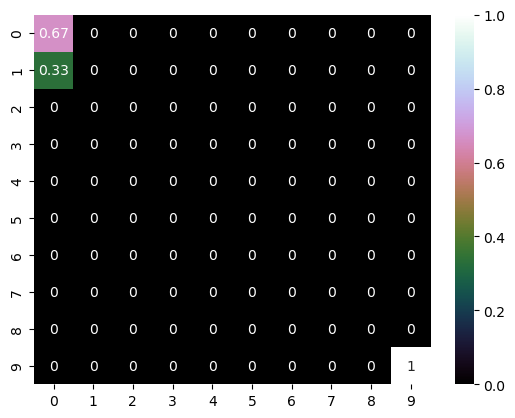

In [90]:
from torcheval.metrics.functional import multiclass_confusion_matrix

nput = torch.tensor([0, 0, 9, 0])
target = torch.tensor([0, 1,9 , 0])




In [8]:
train_loaders_paths=[ "./data/SplitMnist/train/{}".format(x) for x in range(10)]
test_loaders_paths=[ "./data/SplitMnist/test/{}".format(x) for x in range(10)]

Validation loss: 2.319, validation acc 1: 7.117
--------------------------------------------------
[INFO]: Epoch 1 of 40 [0, 1]
Training
Training loss: 0.546, training acc: 82.537
Validation loss: 0.206, validation acc 1: 93.662
--------------------------------------------------
[INFO]: Epoch 2 of 40 [0, 1]
Training
Training loss: 0.171, training acc: 94.862
Validation loss: 0.137, validation acc 1: 95.758
--------------------------------------------------
[INFO]: Epoch 3 of 40 [0, 1]
Training
Training loss: 0.131, training acc: 95.980
Validation loss: 0.121, validation acc 1: 96.257
--------------------------------------------------
[INFO]: Epoch 4 of 40 [0, 1]
Training
Training loss: 0.110, training acc: 96.663
Validation loss: 0.102, validation acc 1: 96.833
--------------------------------------------------
[INFO]: Epoch 5 of 40 [0, 1]
Training
Training loss: 0.099, training acc: 96.998
Validation loss: 0.090, validation acc 1: 97.163
-----------------------------------------------

KeyboardInterrupt: 

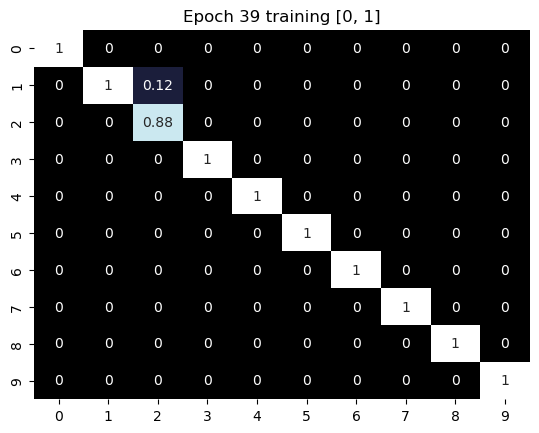

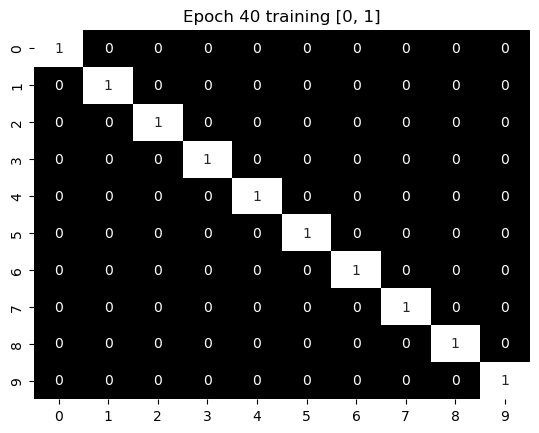

In [77]:
#train_loaders_paths=[ "./data/SplitMnist/train/{}".format(x) for x in range(10)]
#test_loaders_paths=[ "./data/SplitMnist/test/{}".format(x) for x in range(10)]


torch.manual_seed(887)
L_activations=["silu","leakyrelu","sigmoid","relu","gelu","tanh"]
L_inits=["kaiming_uniform"]



All=list(range(10))
patience=3
Margin=0.05
for i in range(len(L_activations)):
    for t,exp in enumerate(ListExperiences):
        L_train_acc=[]
        L_train_loss=[]
        L_test_acc_0=[]
        L_test_loss_0=[]
        
        L2=[k for k in All if k not in exp] 
        train_IF=ClassSpecificImageFolder( root="./data/SplitMnist/train/",dropped_classes=L2,transform=transforms.Compose([ transforms.ToTensor(),transforms.Grayscale(1)]))
        T_DL = DataLoader(dataset=train_IF, batch_size=90, num_workers=0, shuffle=True)
        test_IF=ClassSpecificImageFolder( root="./data/SplitMnist/test/",dropped_classes=L2,transform=transforms.Compose([ transforms.ToTensor(),transforms.Grayscale(1)]))
        Ts_DL = DataLoader(dataset=train_IF, batch_size=90, num_workers=0, shuffle=True)

        model = CNN(1,L_activations[i],0,L_inits[0])
        if not(os.path.isdir('./checkpoints/')):
            os.mkdir('./checkpoints/')
        if not(os.path.isdir('./checkpoints/{}/'.format(exp))):
            os.mkdir('./checkpoints/{}/'.format(exp))
        if not(os.path.isdir('./checkpoints/{}/{}'.format(exp,L_activations[i]))):
            os.mkdir('./checkpoints/{}/{}'.format(exp,L_activations[i]))
        if not(os.path.isdir('./checkpoints/{}/{}/metrics/'.format(exp,L_activations[i]))):
            os.mkdir('./checkpoints/{}/{}/metrics/'.format(exp,L_activations[i]))


        # lists to keep track of losses and accuracies
        train_loss, valid_loss_0 = [], [] 
        train_acc, valid_acc_0 = [], []
        train_confus,test_confus =[] , []
        Brain=copy.deepcopy(model)
        Brain=Brain.to(device)

        optimizer = Adam(Brain.parameters(), lr=0.05)
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-3, max_lr=0.1, step_size_up=1, mode="triangular2", cycle_momentum=False)

        criterion = CrossEntropyLoss()

        valid_epoch_loss0, valid_epoch_acc0,L_mx_st = validate(Brain, Ts_DL,criterion,10)
        valid_loss_0.append(valid_epoch_loss0)
        valid_acc_0.append(valid_epoch_acc0)
        test_confus.append(L_mx_st)
        #print(f"Validation loss: {valid_epoch_loss0:.3f}, validation acc 1: {valid_epoch_acc0:.3f}")

        #print('-'*50)
        # start the training
        stagnate=0
        for epoch in range(40):
            print(f"[INFO]: Epoch {epoch+1} of 40" , t ,L_activations[i])
            train_epoch_loss, train_epoch_acc ,L_mx = train(Brain, T_DL, optimizer, criterion,10)
            train_confus.append(L_mx)
            train_loss.append(train_epoch_loss)
            train_acc.append(train_epoch_acc)
            valid_epoch_loss0, valid_epoch_acc0,L_mx= validate(Brain, Ts_DL,  criterion,10)
            test_confus.append(L_mx)
            valid_loss_0.append(valid_epoch_loss0)
            valid_acc_0.append(valid_epoch_acc0)
            print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
            print(f"Validation loss: {valid_epoch_loss0:.3f}, validation acc 1: {valid_epoch_acc0:.3f}")

            if (valid_epoch_acc0 >60) and (epoch >= 9):
                if epoch %5==1:
                    torch.save({'epoch': aux,'model_state_dict': Brain.state_dict(),'optimizer_state_dict': optimizer.state_dict(),},'./checkpoints/{}/{}/checkpoint epoch {}.pth'.format(exp,L_activations[i],epoch))
                if (abs(valid_epoch_acc0-valid_acc_0[-2])<=Margin)  :
                    print("stagnation")
                    stagnate=stagnate+1
                    if stagnate==patience :
                        epoch=-1
                    else:
                        continue
                else:
                    stagnate=0
                aux=epoch
                if (epoch==-1) :
                    aux=epoch
                    break
            print('-'*50)


        #torch.save(Brain.state_dict(),'./checkpoints/{}/{}/{}/checkpoint.pth'.format(ListExperiences[exp_idx][:5],activ,init))
        torch.save({'epoch': aux,'model_state_dict': Brain.state_dict(),'optimizer_state_dict': optimizer.state_dict(),},'./checkpoints/{}/{}/checkpoint.pth'.format(exp,L_activations[i]))
        L_train_acc.append(train_acc)
        L_train_loss.append(train_loss)
        L_test_acc_0.append(valid_acc_0)
        L_test_loss_0.append(valid_loss_0)

        direct='./checkpoints/{}/{}/metrics/'.format(exp,L_activations[i])
        M=np.array(L_test_acc_0) 
        np.save(direct+"Test Accuracy IID.npy", M)

        H=np.array(L_test_loss_0)
        np.save(direct+"Test Loss IID.npy",H)


        N=np.array(L_train_acc)
        np.save(direct+"Train Acc.npy",N)

        O=np.array(L_train_loss)
        np.save(direct+"Train Loss.npy",O)
        
        P=[train_confus[i][-1].cpu() for i in range(len(train_confus))]
        P=torch.stack(P)
        P=np.transpose(P, (1, 2, 0))
        np.save(direct+"multiclass train Confusion matrix raw.npy",P)
        
        W=[test_confus[i][-1].cpu() for i in range(len(test_confus))]
        W=torch.stack(W)
        W=np.transpose(W, (1, 2, 0))
        np.save(direct+"multiclass test Confusion matrix raw.npy",W)
        
        fig, ax = plt.subplots() 
        ax.cla()
        animation = FuncAnimation(fig, create_frame, frames=len(train_confus), fargs=(ax,train_confus))
        wr=PillowWriter(fps=1)
        animation.save('./checkpoints/{}/{}/metrics/Training mcx.gif'.format(exp,L_activations[i]) , writer=wr)
        fig, ax = plt.subplots() 
        ax.cla()
        animation = FuncAnimation(fig, create_frame, frames=len(test_confus), fargs=(ax,test_confus))
        wr=PillowWriter(fps=1)
        animation.save('./checkpoints/{}/{}/metrics/Testing mcx.gif'.format(exp,L_activations[i]) , writer=wr)


10


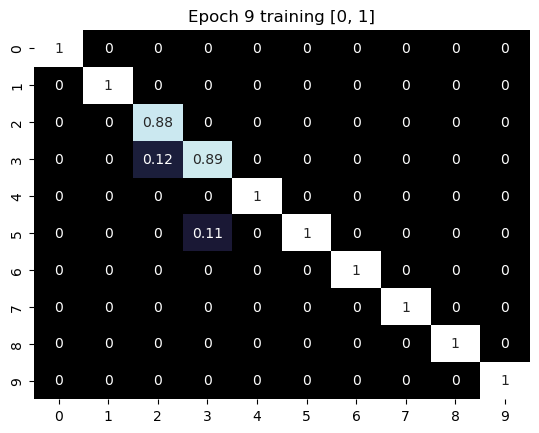

In [ ]:
patience=3
Margin=0.05
L_train_acc=[]
L_test_acc_0=[]
L_test_loss_0=[]
L_test_acc_1=[]
L_test_loss_1=[]
L_train_loss=[]

train_loaders_paths=[ "./data/SplitMnist/{}/train/".format(x) for x in range(10)]
test_loaders_paths=[ "./data/SplitMnist/{}/test/".format(x) for x in range(10)]
image_datasets = torch.utils.data.ConcatDataset(l)
#test_0_dirpath=r"./data/SplitMnist/{}/test 0/".format(ListExperiences[exp_idx][:5])
#test_1_dirpath=r"./data/SplitMnist/{}/test 1/".format(ListExperiences[exp_idx][:5])
#dirpath=r"./data/SplitMnist/{}/train/fold 20/".format(ListExperiences[exp_idx][:5])

train_IF=ImageFolder(dirpath,transforms.Compose([ transforms.ToTensor(),transforms.Grayscale(1)]))
test0_IF=ImageFolder(test_0_dirpath,transform = transforms.Compose([ transforms.ToTensor(),transforms.Grayscale(1) ]) )
test1_IF=ImageFolder(test_1_dirpath,transform = transforms.Compose([ transforms.ToTensor(),transforms.Grayscale(1) ]) )

test_dataloader_custom0 = DataLoader(dataset=test0_IF, batch_size=60, num_workers=0, shuffle=True)
test_dataloader_custom1 = DataLoader(dataset=test1_IF, batch_size=60, num_workers=0, shuffle=True)
train_dataloader_custom = DataLoader(dataset=train_IF, batch_size=60, num_workers=0, shuffle=True) 



model = CNN(1,activ,0,init)
if not(os.path.isdir('./checkpoints/')):
    os.mkdir('./checkpoints/')
if not(os.path.isdir('./checkpoints/{}/'.format(ListExperiences[exp_idx][:5]))):
    os.mkdir('./checkpoints/{}/'.format(ListExperiences[exp_idx][:5]))
if not(os.path.isdir('./checkpoints/{}/{}'.format(ListExperiences[exp_idx][:5],activ))):
    os.mkdir('./checkpoints/{}/{}'.format(ListExperiences[exp_idx][:5],activ))
if not(os.path.isdir('./checkpoints/{}/{}/{}'.format(ListExperiences[exp_idx][:5],activ,init))):
    os.mkdir('./checkpoints/{}/{}/{}'.format(ListExperiences[exp_idx][:5],activ,init))
if not(os.path.isdir('./checkpoints/{}/{}/{}/'.format(ListExperiences[exp_idx][:5],activ,init))):
    os.mkdir('./checkpoints/{}/{}/{}/'.format(ListExperiences[exp_idx][:5],activ,init))

# lists to keep track of losses and accuracies
train_loss, valid_loss_0 ,valid_loss_1= [], [] ,[]
train_acc, valid_acc_0 ,valid_acc_1= [], [], []
Brain=copy.deepcopy(model)
Brain=Brain.to(device)

optimizer = Adam(Brain.parameters(), lr=0.05)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-3, max_lr=0.1, step_size_up=1, mode="triangular2", cycle_momentum=False)

criterion = CrossEntropyLoss()

valid_epoch_loss0, valid_epoch_acc0 = validate(Brain, test_dataloader_custom0,criterion)
valid_loss_0.append(valid_epoch_loss0)
valid_acc_0.append(valid_epoch_acc0)
print(f"Validation loss: {valid_epoch_loss0:.3f}, validation acc 1: {valid_epoch_acc0:.3f}")


valid_epoch_loss1, valid_epoch_acc1 = validate(Brain, test_dataloader_custom1,criterion)
valid_loss_1.append(valid_epoch_loss1)
valid_acc_1.append(valid_epoch_acc1)
print(f"Validation loss: {valid_epoch_loss1:.3f}, validation acc 2: {valid_epoch_acc1:.3f}")
print('-'*50)
# start the training
stagnate=0
for epoch in range(40):
    print(f"[INFO]: Epoch {epoch+1} of 40")
    train_epoch_loss, train_epoch_acc = train(Brain, train_dataloader_custom, optimizer, criterion)
    valid_epoch_loss0, valid_epoch_acc0 = validate(Brain, test_dataloader_custom0,  criterion)
    train_loss.append(train_epoch_loss)
    valid_loss_0.append(valid_epoch_loss0)
    train_acc.append(train_epoch_acc)
    valid_acc_0.append(valid_epoch_acc0)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss0:.3f}, validation acc 1: {valid_epoch_acc0:.3f}")
    valid_epoch_loss1, valid_epoch_acc1 = validate(Brain, test_dataloader_custom1,  criterion)

    valid_loss_1.append(valid_epoch_loss1)
    valid_acc_1.append(valid_epoch_acc1)
    print(f"Validation loss: {valid_epoch_loss1:.3f}, validation acc 2: {valid_epoch_acc1:.3f}")
    if (valid_epoch_acc0 >60) and (epoch >= 9):
        if epoch %5==1:
            torch.save({'epoch': aux,'model_state_dict': Brain.state_dict(),'optimizer_state_dict': optimizer.state_dict(),},'./checkpoints/{}/{}/{}/checkpoint epoch {}.pth'.format(ListExperiences[exp_idx][:5],activ,init,epoch+1))
        if (abs(valid_epoch_acc0-valid_acc_0[-2])<=Margin)  :
            print("stagnation")
            stagnate=stagnate+1
            if stagnate==patience :
                epoch=-1
            else:
                continue
        else:
            stagnate=0
        aux=epoch
        if (epoch==-1) :
            aux=epoch
            break
    print('-'*50)


#torch.save(Brain.state_dict(),'./checkpoints/{}/{}/{}/checkpoint.pth'.format(ListExperiences[exp_idx][:5],activ,init))
torch.save({'epoch': aux,'model_state_dict': Brain.state_dict(),'optimizer_state_dict': optimizer.state_dict(),},'./checkpoints/{}/{}/{}/checkpoint.pth'.format(ListExperiences[exp_idx][:5],activ,init))
L_train_acc.append(train_acc)
L_train_loss.append(train_loss)
L_test_acc_0.append(valid_acc_0)
L_test_loss_0.append(valid_loss_0)
L_test_acc_1.append(valid_acc_1)
L_test_loss_1.append(valid_loss_1)
direct='./checkpoints/{}/{}/{}/'.format(ListExperiences[exp_idx][:5],activ,init)
M=np.array(L_test_acc_0) 
np.save(direct+"Test Accuracy IID.npy", M)

H=np.array(L_test_loss_0)
np.save(direct+"Test Loss IID.npy",H)

W=np.array(L_test_acc_1)
np.save(direct+"Test Accuracy OOD.npy",W)

V=np.array(L_test_loss_1)
np.save(direct+"Test Loss OOD.npy",V)

N=np.array(L_train_acc)
np.save(direct+"Train Acc.npy",N)

O=np.array(L_train_loss)
np.save(direct+"Train Loss.npy",O)



In [ ]:
L_activations=["leakyrelu","sigmoid","relu","tanh","silu","gelu"]
inits="kaiming_uniform"

split_mnist = SplitMNIST(n_experiences=1)

for i in product(L_activations): 
    print(list(i))
    model = CNN(1,nlin=list(i)[0],init_type=list(i)[1])
    model=model.to(device)

    optimizer = Adam(model.parameters(), lr=0.05)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-3, max_lr=0.1, step_size_up=1, mode="triangular2", cycle_momentum=False)